In [1]:
# load model and make automarker
# TODO: mark a range of images, not all because at the begining the model have low accuracy

In [2]:
import os
import cv2
import json
import numpy as np
import tensorflow as tf
from utils import load_image
import matplotlib.pyplot as plt
from imutils.paths import list_images

In [3]:
eye_detector = tf.keras.models.load_model('eye_detector_model.hdf5')

2022-07-28 21:22:02.143969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 21:22:02.170355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 21:22:02.170748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 21:22:02.171325: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [4]:
f'{eye_detector.count_params():,} total params'

'63,920 total params'

In [5]:
datapath = {
    'images_path': "/home/choppy/TOC/thesis-msc-2022/data/images/aws/bonafide/unmarked",
    'via_file': None
}

images_path = sorted([*list_images(datapath.get('images_path'))])

In [6]:
image = load_image(np.random.choice(images_path))
image.shape

(380, 214, 3)

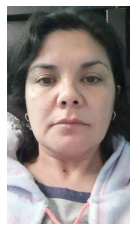

In [7]:
plt.imshow(image)
plt.axis('off')
plt.show()

In [8]:
# redim image
original_shape = image.shape[:] # h, w, c = image.shape
image_input = cv2.resize(image, (224, 224))
# create new axis
image_input = image_input[np.newaxis, ...]

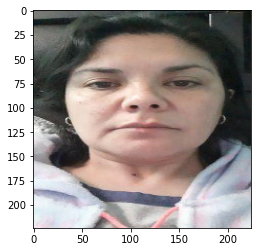

In [9]:
plt.imshow(image_input[0])

In [10]:
# format image and do inference
image_input = image_input  / 255.

pred = eye_detector.predict(image_input)[0]

2022-07-28 21:22:04.506461: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-07-28 21:22:04.993532: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-28 21:22:04.993871: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-28 21:22:04.993889: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-07-28 21:22:04.994247: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-28 21:22:04.994293: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [11]:
h, w, c = original_shape
pred = pred * [w, h, w, h] # image width, height
pred = pred.astype(np.int32)
pred

array([ 53, 126, 160, 187], dtype=int32)

In [12]:
pt1 = pred[:2]
pt2 = pred[2:]
rect_image = image = cv2.rectangle(image, pt1, pt2, [200, 50, 50], thickness=2)

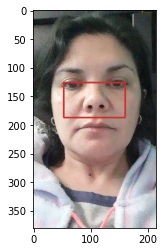

In [13]:
plt.imshow(rect_image)

In [14]:
# select range of images
_from = 0
_to = 50

# make via json format
via_json = {}

for i in range(_from, _to):
    impath = images_path[i]
    filename = os.path.basename(impath)
    image = load_image(impath)
    
    original_shape = image.shape[:] # h, w, c = image.shape
    image_input = cv2.resize(image, (224, 224))
    image_input = image_input[np.newaxis, ...]
    image_input = image_input  / 255.
    
    pred = eye_detector.predict(image_input)[0]
    
    h, w, c = original_shape
    pred = pred * [w, h, w, h] # image width, height
    pred = pred.astype(np.int32)
    
    x_start, y_start, x_end, y_end = pred
    x_end = x_end - x_start
    y_end = y_end - y_start
    
    # structure
    # {
    #     "M2E0M2VkO0EyMTIzMDg1.png143502": {
    #         "filename": "M2E0M2VkO0EyMTIzMDg1.png",
    #         "size": 143502,
    #         "regions": [
    #             {
    #                 "shape_attributes": {
    #                     "name": "rect",
    #                     "x": 62,
    #                     "y": 137,
    #                     "width": 106,
    #                     "height": 47
    #                 },
    #                 "region_attributes": {
    #                     "Face": "Periocular"
    #                 }
    #             }
    #         ],
    #         "file_attributes": {}
    #     },
    # }
    
    filesize = os.path.getsize(impath)
    obj = {
        "filename": filename,
        "size": filesize,
        "regions": [
            {
                "shape_attributes": {
                    "name": "rect",
                    "x": int(x_start),
                    "y": int(y_start),
                    "width": int(x_end),
                    "height": int(y_end),
                },
                "region_attributes": {
                    "Face": "Periocular"
                }
            }
        ],
        "file_attributes": {}
    }
    
    via_json[f'{filename}{filesize}'] = obj
    
    
    
#     pt1 = pred[:2]
#     pt2 = pred[2:]
#     rect_image = image = cv2.rectangle(image, pt1, pt2, [200, 50, 50], thickness=2)
    
#     plt.imshow(image)
#     plt.axis('off')
#     plt.show()

In [15]:
json.dump(via_json, open('regs.json', 'w'))